/tmp/ipykernel_253597/857786944.py:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')


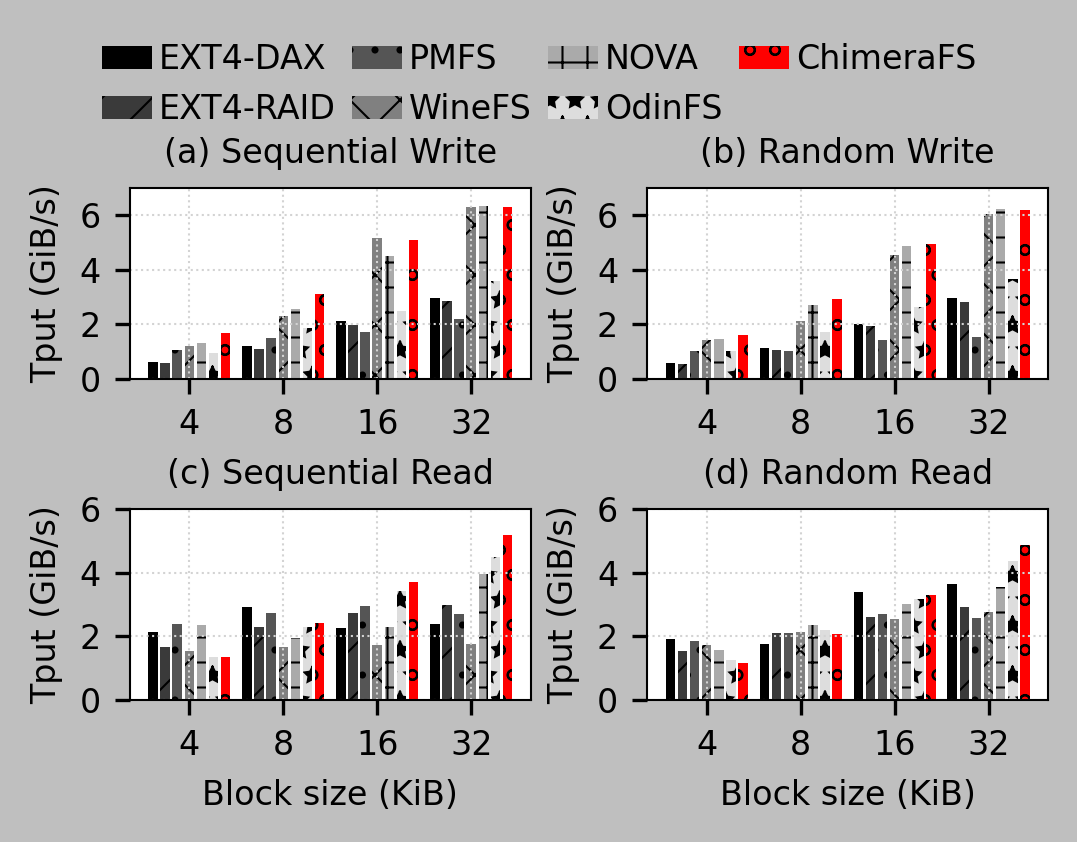

In [1]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54

# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

# Filter data for numjobs=1
df = df[df['numjobs'] == 1]

fig = plt.figure(dpi=300, figsize=(cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(6)))

fss = ["ext4-dax", "ext4-raid", "pmfs", "winefs", "nova", "odinfs-12", "parfs-12"]
df['bandwidth'] = df['bandwidth(MiB/s)'] / 1024  # Convert to GiB/s

mapping = {
    "nova": "NOVA",
    "pmfs": "PMFS",
    "ext4-dax": "EXT4-DAX",
    "ext4-raid": "EXT4-RAID",
    "winefs": "WineFS",
    "odinfs-12": "OdinFS",
    "parfs-12": "ChimeraFS",
}
mapped_fss = [mapping.get(fs, fs) for fs in fss]

subplot_config = [
    {'row': 0, 'col': 0, 'blk_sz': 4096, 'op': 'write', 'title_label': 'a', 'y_lims': [0, 7]},
    {'row': 0, 'col': 1, 'blk_sz': 8192, 'op': 'randwrite', 'title_label': 'b', 'y_lims': [0, 7]},
    {'row': 1, 'col': 0, 'blk_sz': 16384, 'op': 'read', 'title_label': 'c', 'y_lims': [0, 6]},
    {'row': 1, 'col': 1, 'blk_sz': 32768, 'op': 'randread', 'title_label': 'd', 'y_lims': [0, 6]},
]

# subplot_config = [
#     {'row': 0, 'col': 0, 'op': 'write', 'title_label': 'a'},
#     {'row': 0, 'col': 1, 'op': 'randwrite', 'title_label': 'b'},
#     {'row': 1, 'col': 0, 'op': 'overwrite', 'title_label': 'c'},
#     {'row': 1, 'col': 1, 'op': 'randoverwrite', 'title_label': 'd'},
#     {'row': 2, 'col': 0, 'op': 'read', 'title_label': 'e'},
#     {'row': 2, 'col': 1, 'op': 'randread', 'title_label': 'f'},
# ]

# op_type_map = {
#     'write': 'Seq Write',
#     'read': 'Seq Read',
#     'randwrite': 'Rnd Write',
#     'randread': 'Rnd Read',
#     'overwrite': 'Seq Overwrite',
#     'randoverwrite': 'Rnd Overwrite'
# }

op_type_map = {
    'write': 'Sequential Write',
    'read': 'Sequential Read',
    'randwrite': 'Random Write',
    'randread': 'Random Read',
}

blksz_str_map = {
    4096: '4',
    8192: '8',
    16384: '16',
    32768: '32'
}

hatches = ['', '//', '..', 'xx', '++', '**', 'oo', '||']
# give me seven grayscale color
colors = ["black", "#3a3a3a", "#555555", "#808080", "#aaaaaa", "#dddddd", "red"]
edge_colors = ['black' if fs != 'parfs-12' else 'firebrick' for fs in fss]

lines = []
for i, config in enumerate(subplot_config):
    plt.subplot(2, 2, i+1)
    op = config['op']
    data_subset = df[df['ops'] == op]
    blksz_list = sorted(data_subset['blksz'].unique())
    
    x = np.arange(len(blksz_list))
    n_fs = len(fss)
    width = 0.9 / n_fs  # Adjust width based on number of file systems
    
    # min_bws = [10000000, 10000000, 10000000, 10000000]
    min_bws = [1, 1, 1, 1]
    # for blk_idx, blksz in enumerate(blksz_list):
    #     for fs_idx, fs in enumerate(fss):
    #         filtered = data_subset[(data_subset['fs'] == fs) & (data_subset['blksz'] == blksz)]
    #         if not filtered.empty:
    #             bw = filtered['bandwidth'].iloc[0]
    #             if bw < min_bws[blk_idx]:
    #                 min_bws[blk_idx] = bw
    
    for fs_idx, fs in enumerate(fss):
        y = []
        for blk_idx, blksz in enumerate(blksz_list):
            filtered = data_subset[(data_subset['fs'] == fs) & (data_subset['blksz'] == blksz)]
            y.append(filtered['bandwidth'].iloc[0] / min_bws[blk_idx] if not filtered.empty else 0)
        x_pos = x + fs_idx * width
        bars = plt.bar(x_pos, y, width=width * 4/5, 
                       hatch=hatches[fs_idx],
                       color=colors[fs_idx],
                       linewidth=0.5,
                       label=mapped_fss[fs_idx] if i == 0 else '_nolegend_')
        if i == 0:
            lines.append(bars[0])
    
    plt.title(f"({config['title_label']}) {op_type_map[op]}", fontsize=8)
    plt.xticks(x + (n_fs-1)*width/2, [blksz_str_map[b] for b in blksz_list], fontsize=8)
    plt.ylim(config['y_lims'])
    plt.yticks([0, 2, 4, 6], fontsize=8)
    if config['row'] == 1:
        plt.xlabel('Block size (KiB)', fontsize=8)
    # if config['col'] == 0:
    plt.ylabel('Tput (GiB/s)', fontsize=8)

    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)

# fig.legend(lines, mapped_fss, loc='upper center', 
#           bbox_to_anchor=(0.5, 1.05), ncol=7,
#           columnspacing=1, handletextpad=0, 
#           handlelength=1.5, frameon=False, fontsize=8)
fig.legend(lines, mapped_fss, loc='center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=8, frameon=False, columnspacing=0.5, handletextpad=0.2, handlelength=1.5)

plt.tight_layout(pad=0.4)
plt.savefig("./FIO-BS.pdf", bbox_inches='tight', pad_inches=0)